<a href="https://colab.research.google.com/github/kwcooper/CL_neuromatch/blob/main/continual_learning_neuromatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week ?, Day ?, Tutorial ?
# Introduction to Continual Learning

__Content creators:__ [Keiland Cooper](http://kwcooper.xyz), [Diganta Misra](https://digantamisra98.github.io/), Name Surname, Name Surname, Name Surname, ... 


__Content reviewers:__ Name Surname, Name Surname. This includes both reviewers and editors. 


In [ ]:
#@title Video 0: Overview of the session and introduction to continual learning [to be created]
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


---
#Tutorial Objectives



(Will update)
In this tutorial we'll dive head-first into the exciting field of continual learning (CL). CL has gained increasing attention in recent years, and for good reason. CL is postioned as a problem accross sub-disaplanes, from academia and industry, and may promise to be a major pathway towards strong artificial intelligence. As datasets get bigger and AI gets smarter, we're expecting more and more cognitive capabilities from our machines. 

We have a few specific objectives for this tutorial:
*   Introduce students to major CL concepts
*   Introduce the most common strategies to aid CL
*   Utilize benchmarks and evaluation metrics 
*   Explore present day applications of CL 


_Use a line (---) separator from title block to objectives. You should briefly introduce your content here in a few sentences. In this tutorial, you will learn what a waxed notebook should look like. **You should make sure the notebook runs from start to finish when done waxing (do restart and run all and make sure there are no errors)**_



---
# Setup

First, let's load in some usefule packages and functions. We'll primarly be using PyTorch as our neural network framework of choice. Be sure to run all the cells below so the code runs properly. 

In [ ]:
# Imports

# If any external library has to be installed, !pip install library --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch # should work natively now 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F



In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Configure PyTorch

# PyTorch Configuration
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

if not torch.cuda.is_available():
  print('For quicker runtime, add GPU at Runtime -> Change runtime type -> Hardware accelerator -> GPU')

else:
  # switch to False to use CPU
  use_cuda = True

  use_cuda = use_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu");

# set the seed
torch.manual_seed(1);

Torch 1.8.1+cu101 CUDA 10.1


In [ ]:
#@title Data-loader Helper functions

# TODO:
# We need a more permenate solution for this... 
# https://github.com/pytorch/vision/issues/1938

# we should also probably supress most of this output 
# unless we change the source of the data

print('Downloading and unpacking MNIST data. Please wait a moment...\n')

# The MNIST repo on LeCun's website nor AWS seem to be availible
# This is one popular private repo, but beware
# PyTorch is reported to be hosting one soon...
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

mnist_train = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=True)
mnist_test = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=False)

def load_mnist(verbose=False, asnumpy=True):
    '''
    Helper function to maintain compatability with
    previous MNIST dataloaders in CLAI COLAB

    Much of this can likely now be fixed with the toTensor call on inport
    Or by using proper PyTorch functions... lol

    - KWC
    '''
    
    x_traint, t_traint = mnist_train.data, mnist_train.targets
    x_testt, t_testt = mnist_test.data, mnist_test.targets
    
    if asnumpy: 
      # Fix dimensions and convert back to np array for code compatability
      # We aren't using torch dataloaders for ease of use
      x_traint = torch.unsqueeze(x_traint, 1)
      x_testt = torch.unsqueeze(x_testt, 1)
      x_train, x_test = x_traint.numpy().copy(), x_testt.numpy()
      t_train, t_test = t_traint.numpy().copy(), t_testt.numpy()
    else:
      x_train, t_train = x_traint, t_traint
      x_test, t_test = x_testt, t_testt

    if verbose: 
      print("x_train dim and type: ", x_train.shape, x_train.dtype)
      print("t_train dim and type: ", t_train.shape, t_train.dtype)
      print("x_test dim and type: ", x_test.shape, x_test.dtype)
      print("t_test dim and type: ", t_test.shape, t_test.dtype)
      print()


    return x_train, t_train, x_test, t_test
           


--2021-05-24 08:03:42--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-24 08:03:43--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [             <=>    ]  33.20M  11.7MB/s    in 2.8s    

2021-05-24 08:03:46 (11.7 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/ra

In [ ]:
#@title Plotting and Utils Helper functions

# If any helper functions you want to hide for clarity, add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


def plot_mnist(data, nPlots=10):
  """ Plot MNIST-like data """
  f, axarr = plt.subplots(1,nPlots)
  for ii in range(nPlots):
    axarr[ii].imshow(data[ii,0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);
  plt.show()


def permute_mnist(mnist, seed, verbose=False):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    if verbose: print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    if verbose: print("done.")
    return perm_mnist


def multi_task_barplot(accs, tasks, t=None):
  ''' Plot n task accuracy
      used for S1 intro to CF code '''
  nTasks = len(accs)
  plt.bar(range(nTasks), accs, color='k')
  plt.ylabel('Testing Accuracy (%)', size=18)
  plt.xticks(range(nTasks), 
            [f'{TN}\nTask {ii+1}' for ii,TN in enumerate(tasks.keys())], 
            size=18)
  plt.title(t)


---

# Section X: Example neuromatch code to be deleted

### Exercise 1: Helpful exercise name (ex. fitting a linear regression model)

This exercise fits in this subsection so is a level 3 header

Very briefly summarize the exercise here. In this exercise, you will also invoke `multiply_array` which multiplies an array by a scalar

In [ ]:
def generic_function(x):
  """Google style doc string. Brief summary of what function does here
  
  Args:
    x (ndarray): An array of shape (N,) that contains blah blah

  Returns:
    ndarray: The output is blah blah
  """Created using Colaboratory
  #################################################
  ## TODO for students: details of what they should do ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: say what they should have done")
  #################################################
  
  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(..., 5)

  # Another comment because they need to add another line of code
  z = ...

  return z

x = np.array([4, 5, 6])
z = generic_function(x)

# we usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code
plotting_z(z)

SyntaxError: ignored

---
__Editor guideline for exercise solution formatting:__
- the presence of # to_remove solution in the first line of solution block
- The absence of the fenced (#####) block that raises a NotImplementedError
- Valid code replacing all ellipses  (...)
- Code that uses or depends on the completed function/lines is uncommented
- Plotting code is indented under a with plt.xkcd(): context manager.
- **All other comments and code should be identical**
---

In [ ]:
# to_remove solution
def generic_function(x):
  """Google style doc string. Brief summary of what function does here
  
  Args:
    x (ndarray): An array of shape (N,) that contains blah blah

  Returns:
    ndarray: The output is blah blah
  """

  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(x, 5)

  # Another comment because they need to add another line of code
  z = y + 6

  return z

x = np.array([4, 5, 6])
z = generic_function(x)

# we usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code
# xkcd style for solution plot
with plt.xkcd():  
  plotting_z(z)

### Interactive Demo: Name of demo

Here, we will demonstrate how to create a widget if you would like to use a widget to demonstrate something. Make sure the use a @title cell and hide the contents by default, because the code to make the widget is often pretty ugly and not important for the students to see. Also, we recommend giving specific guidance for what students should look at with widget/what questions they're trying to answer so it's not just pointless twiddling.

If the widget makes use of a function that must be completed as part of an exercise, you may want to re-implement the correct version of the function inside the widget cell, so that it is useful for a student who got completely stuck.


In [ ]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)

def gaussian(x, mu, sigma):
  px = np.exp(-1 / 2 / sigma**2 * (mu - x) ** 2)
  px = px / px.sum()
  return px

@widgets.interact
def plot_gaussian(mean=(-10, 10, .5), std=(.5, 10, .5)):
  plt.plot(x, gaussian(x, mean, std))


In [ ]:
# to_remove explanation

"""
Discussion: Write a dicussion about/answers to any open-ended questions you pose (either about a demo or elsewhere)

You can write a paragraph or two of nice didactic text
within a single comment. 
""";

__Editor guideline:__ note that the form header for the cell above is __to_remove explanation__, not __to_remove solution__.

maybe some more text about what exercises showed (if helpful). 
The Gaussian is: 
- bumpy in the middle
- symmetric
- almighty

---

# Section 1: The sequential learning problem: catastrophic forgetting 

In [ ]:
#@title Video 1: Introduction to catastrophic forgetting [to be created]
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


_(Text about the first concept. Don't make too long to reduce reading times during tutorial (extra text for later reference can go in appendix))_

Here we'll explore catastrophic forgetting first hand, a key barrier preventing continual learning in neural networks. To do so, we'll build a simple network model and try our best to teach it the trusty MNIST dataset

## Section 1.1: A brief example of catastrophic forgetting 

Let's define a simple CNN that can perform fairly well on MNIST. We'll also load in some training and testing functions we wrote to load the data into the model and train / test it. We don't need to get into the details how they work for now (pretty standard) but feel free to double click the cell if you're curious!

In [ ]:
# Here we define a simple multilayer CNN. Nothing too fancy
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        """ run the network forward 
        (uses the functional library (F) imported from pytorch)"""
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
#@title Model Training and Testing Functions
def train(model, device, x_train, t_train, optimizer, epoch):
    """

    """
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    """

    """
    model.eval()
    correct, test_loss = 0, 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x = torch.from_numpy(x_test[start:end]).type(torch.cuda.FloatTensor)
        y = torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Now let's load in our dataset, MNIST. We'll also run a function we defined in the helper function cell above that permutes (scrambles) the images. This allows us to create aditional datasets with similar statictics to MNIST on the fly. We'll call the normal MNIST Task 1, and the permuted MNIST Task 2. We'll see why in a second!

Task 1: MNIST Training data:


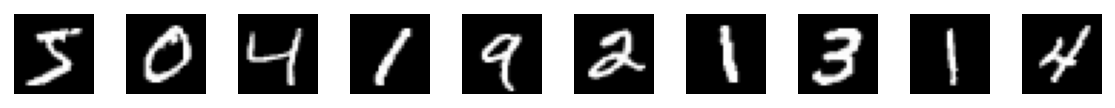


Task 2: Permuted MNIST data:


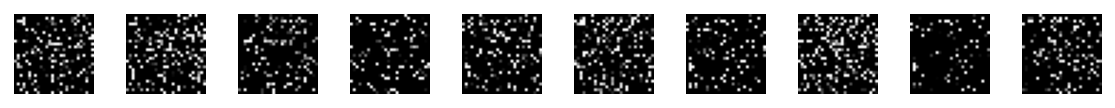

In [ ]:
# Load in MNIST and create an additional permuted dataset
x_train, t_train, x_test, t_test = load_mnist(verbose=False)
x_train2, x_test2 = permute_mnist([x_train, x_test], 0, verbose=False)

# Plot the data to see what we're working with
print('Task 1: MNIST Training data:')
plot_mnist(x_train, nPlots=10)
print('\nTask 2: Permuted MNIST data:')
plot_mnist(x_train2, nPlots=10)


Great! We have our data. Now, let's initialize and train our model on the standard MNIST dataset (Task 1) and make sure everything is working properly. 

In [ ]:
# Define a new model and set params
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model on MNIST
nEpochs = 3 
print(f'Training model on {nEpochs} epochs...')
for epoch in range(1, nEpochs+1):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Training model on 3 epochs...
Train Epoch: 1 	Loss: 1.531727
Test set: Average loss: 0.0004, Accuracy: 8701/10000 (87%)

Train Epoch: 2 	Loss: 0.809245
Test set: Average loss: 0.0002, Accuracy: 9280/10000 (93%)

Train Epoch: 3 	Loss: 1.077803
Test set: Average loss: 0.0001, Accuracy: 9363/10000 (94%)



Okay great! It seems we get decent accuracy on standard MNIST which means the model is learning our dataset. Now, a reasonable assumption is that, like humans, once the network learns something, it can aggregate its knowledge and learn something else. 

First, let's get a baseline for how the model performs on the dataset it was just trained on (Task 1) as well as to see how well it performs on a new dataset (Task 2). 

Testing on task 1
Test set: Average loss: 0.0001, Accuracy: 9363/10000 (94%)

Testing on task 2
Test set: Average loss: 0.0019, Accuracy: 782/10000 (8%)



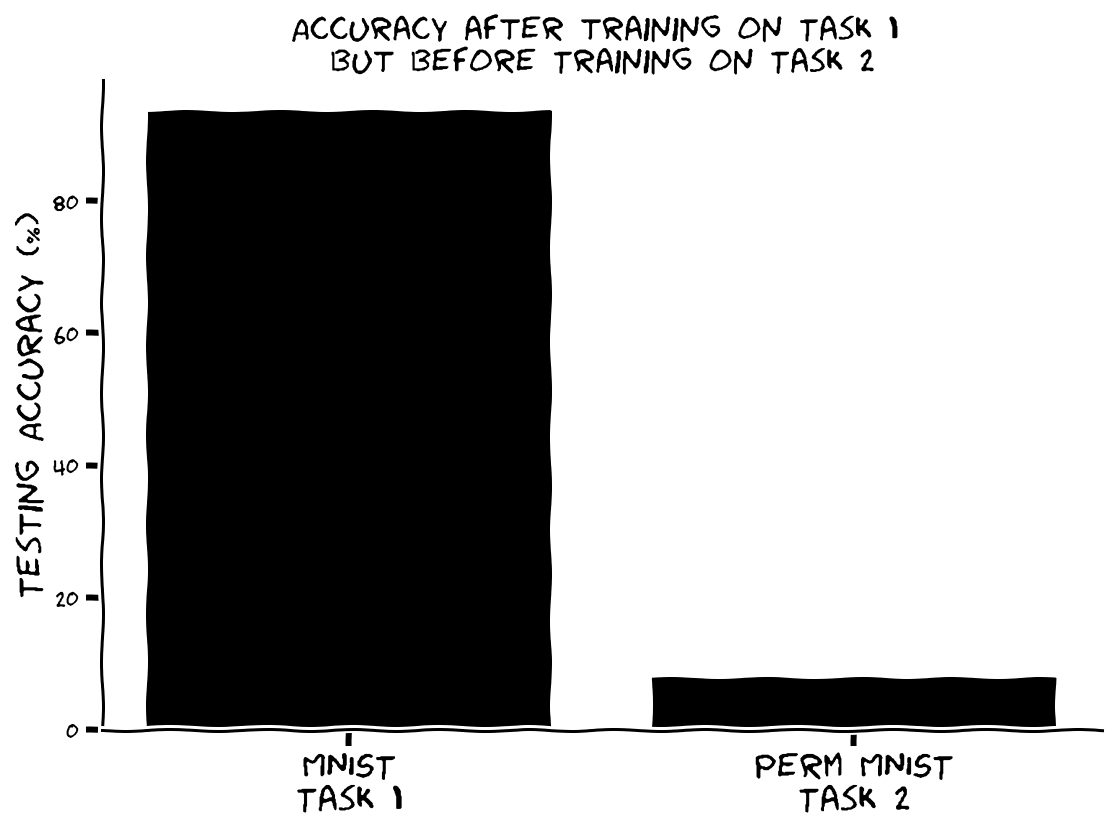

In [ ]:
# test the model's accuracy on both the regular and permuted dataset

# Let's define a dictionary that holds each of the task
# datasets and labels 
tasks = {'MNIST':(x_test, t_test), 
         'Perm MNIST':(x_test2, t_test)}
t1_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti+1}")
  t1_accs.append(test(model, device, tasks[task][0], tasks[task][1]))

# And then let's plot the testing accuracy on both datasets
with plt.xkcd():  
  multi_task_barplot(t1_accs, tasks, 
                     t='Accuracy after training on Task 1 \nbut before Training on Task 2')


As we saw before, the model does great on the Task 1 dataset it was trained on, but not so well on the new one. No worries! We havn't taught it the permuted MNIST dataset yet! So let's train the *same* task 1-trained-model on the new data, and see if we can get comparable performance between the two types of MNIST

Train Epoch: 1 	Loss: 1.843683
Test set: Average loss: 0.0010, Accuracy: 5236/10000 (52%)

Train Epoch: 2 	Loss: 1.780445
Test set: Average loss: 0.0007, Accuracy: 6513/10000 (65%)

Testing on task 1
Test set: Average loss: 0.0020, Accuracy: 1272/10000 (13%)

Testing on task 2
Test set: Average loss: 0.0007, Accuracy: 6513/10000 (65%)



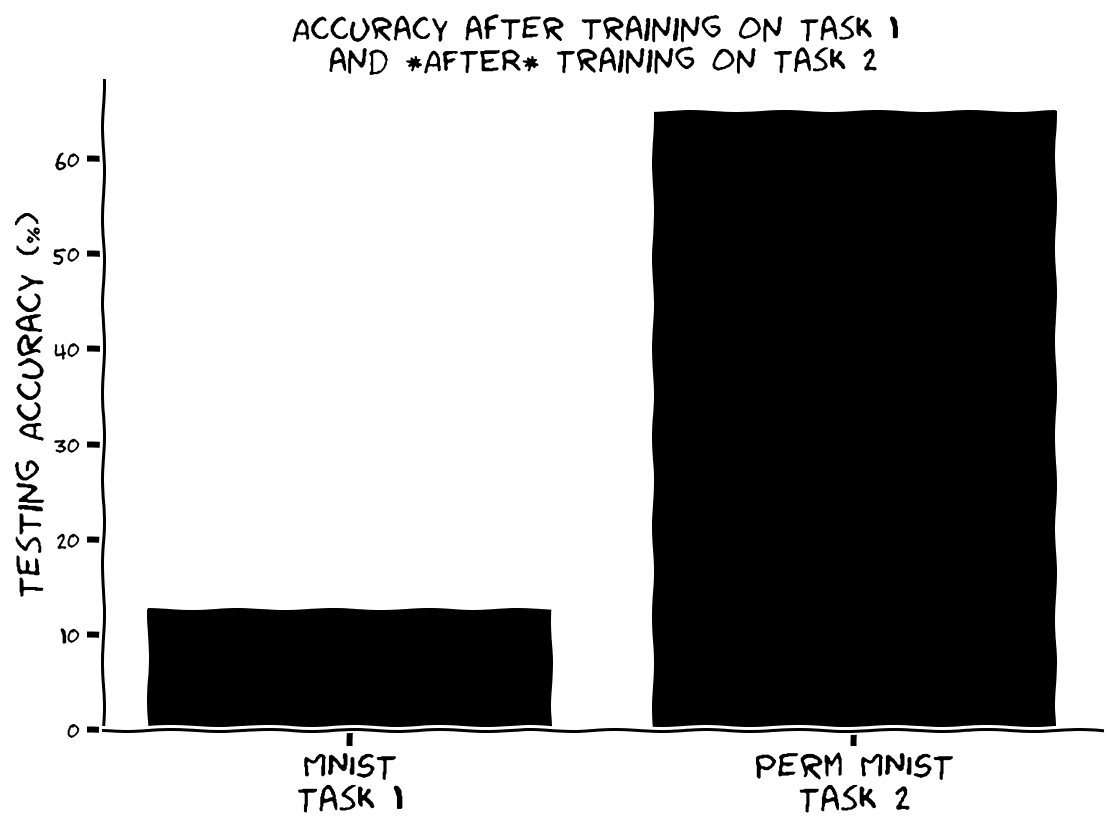

In [ ]:

# Train the previously trained model on Task 2, the permuted MNIST dataset
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

# Same data as before, stored in a dict
tasks = {'MNIST':(x_test, t_test), 
         'Perm MNIST':(x_test2, t_test)}
# Test the model on both datasets, same as before
t12_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti+1}")
  t12_accs.append(test(model, device, tasks[task][0], tasks[task][1]))

# And then let's plot each of the testing accuracies after the new training
with plt.xkcd():  
  multi_task_barplot(t12_accs, tasks, 
                     t='Accuracy after training on Task 1 \nand *AFTER* Training on Task 2')


Hey! Training did the trick, task 2 (permuted MNIST) has great accuracy now that we trained the model on it. But something is wrong. We just saw that Task 1 (standard MNIST) had high accuracy before we trained on the new task. What gives? 

## Section 1.2: Name

### Exercise 2: Name

---
# Section 2: Continual Learning strategies

In this section we will take a look at some of the most prominent and basic continual learning strategies, namely, Rehearsal and Elastic Weight Consolidation (EWC).

To learn more about some of the popular CL strategies, check this [page](https://vlomonaco.github.io/core50/strategies.html#:~:text=Rehearsal%20Strategies%3A%20past%20information%20is,new%20patterns%20for%20future%20training.).

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Rehearsal

Rehearsal is arguably the simplest CL strategy where one simply passes all or some samples from previous tasks in the current task mixed with samples of the current task. 
The performance scales proportionally to the number of samples replayed from previous tasks, however, comes at a cost of memory expense. 

To learn more about rehearsal, check out this [paper](https://arxiv.org/abs/1809.05922).

Before starting with the strategies, let's define our tasks using MNIST/ Permuted MNIST.

In [ ]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

First let's define the function `shuffle_in_unison` that would allow us to shuffle the samples from the previous task with that of the current task.

In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now let's reset our model and optimizer!

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Time to train the model using Rehearsal Strategy and evaluate the performance. 

In [ ]:
rehe_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  
  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 3)
  rehe_accs.append(avg_acc/3)

Training on task:  0
Train Epoch: 1 	Loss: 1.605919
Testing on task:  0
Test set: Average loss: 0.0007, Accuracy: 7133/10000 (71%)

Testing on task:  1
Test set: Average loss: 0.0018, Accuracy: 750/10000 (8%)

Testing on task:  2
Test set: Average loss: 0.0017, Accuracy: 945/10000 (9%)

Avg acc:  29.426666666666666
Training on task:  1
Train Epoch: 1 	Loss: 1.486226
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 8429/10000 (84%)

Testing on task:  1
Test set: Average loss: 0.0006, Accuracy: 4090/10000 (41%)

Testing on task:  2
Test set: Average loss: 0.0008, Accuracy: 1331/10000 (13%)

Avg acc:  46.166666666666664
Training on task:  2
Train Epoch: 1 	Loss: 1.665764
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 8643/10000 (86%)

Testing on task:  1
Test set: Average loss: 0.0004, Accuracy: 5076/10000 (51%)

Testing on task:  2
Test set: Average loss: 0.0004, Accuracy: 3965/10000 (40%)

Avg acc:  58.946666666666665


Perfect! As you can see the average accuracy on all the tasks is pretty solid. However as discussed at the start, the downside of using such replay methods is the high memory cost depending on the number of samples carried ahead from the previous task. 

Here are some follow-up questions to brainstorm on:

1. Can we make Rehearsal more memory efficient?

2. What's a good trade-off between the memory overhead induced by samples from the previous tasks and overall accuracy?

## Elastic Weight Consolidation (EWC)

EWC is a foundational CL strategy which involves computing the importance of weights of the network relative to the task using the Fisher score and then penalizing the network for changes to the most important weights of the previous task. 

It was introduced in the paper "[Overcoming catastrophic forgetting in neural networks
](https://arxiv.org/abs/1612.00796)". 

The main adavantage of using EWC over Rehearsal is that EWC does not require any data of the previous tasks to be replayed again. 

First let's creare the dictionaries to store the fisher scores along with the regularizing co-efficient `ewc_lambda` and further reset our model and optimizer.

In [ ]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our train function to add the new regularization loss:

In [ ]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      
      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Finally we can run the train over the three tasks sequence of th Permuted MNIST:

In [ ]:
ewc_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  for epoch in range(1, 3):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
  on_task_update(id, x_train, t_train)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 3)
  ewc_accs.append(avg_acc / 3)

Training on task:  0


RuntimeError: ignored

Perfect! Let's plot the average accuracy over tasks for both the Rehearsal and EWC Strategies for our three earlier defined tasks.

ValueError: ignored

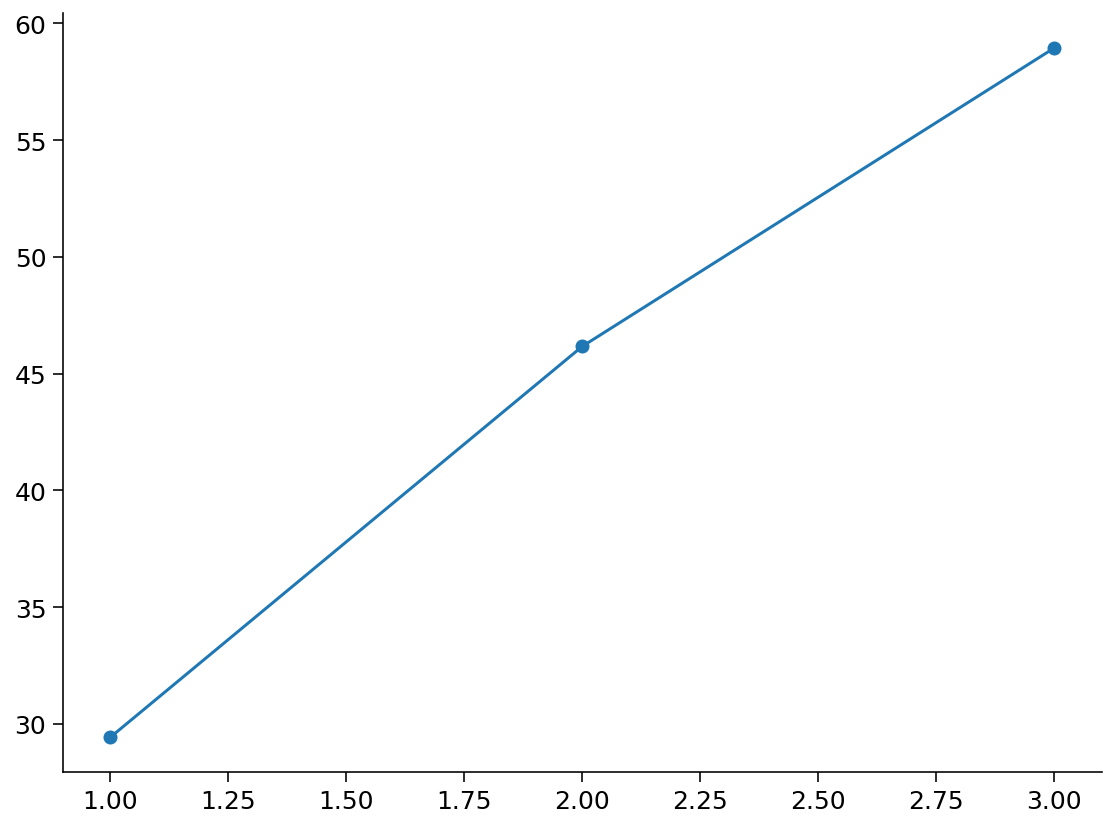

In [ ]:
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

However, there are still some questions that are left to be answered for the efficiency of EWC. We will let you get hands on to answer the same in the next exercise.

## Exercise 2: Test out three different lambda values for EWC and observe their performance.



### Exercise 2: Name

---
# Section 3: Continual learning benchmarks

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


Add some explanitory text here :)

In [ ]:
# add some cool code here

## Exercise n: Name

This exercise is in this section (not in a subsection) so has a level 2 header

In [ ]:
test = 3
test

3

---
# Section 4: Evaluation of continual learning algorithms

Understanding how your CL algorithm is performing is key to gain insights on its behavior and to decide how to improve it. 

Here, we will focus on how to build some of the most important CL metrics!

In [ ]:
#@title Video 2: Continual Learning Evaluation
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


We have already trained the model on T tasks and recorded all the accuracy values in a single TxT matrix.

In [ ]:
import numpy as np

## Average Accuracy

The Average Accuracy (ACC) metric computes the average accuracy over all tasks after training on all tasks.

In [ ]:
def ACC(result_matrix):
  """
  Average Accuracy metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  """

  final_accs = result_matrix[-1, :]  # take accuracies after final training
  acc = np.mean(final_accs)  # compute average
  return acc, final_accs

## Backward Transfer

The Backward Transfer (BWT) metric of task i computes the accuracy on task i after training on last task **minus** the accuracy on task i after training on task i.

To get the average BWT you have to average across all tasks.

**Negative BWT expresses the amount of forgetting suffered by the algorithm.**


In [ ]:
def BWT(result_matrix):
  """
  Backward Transfer metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  """

  final_accs = result_matrix[-1, :]  # take accuracies after final training
  # accuracies on task i right after training on task i, for all i
  training_accs = np.diag(result_matrix)  
  task_bwt = final_accs - training_accs  # BWT for each task
  average_bwt = np.mean(task_bwt)  # compute average
  return average_bwt, task_bwt

## Forward Transfer

The Forward Transfer (FWT) metric of task i computes the accuracy on task i after training on task i-1 **minus** the accuracy on experience i at model initialization (before training on any task).

To get the average FWT you have to average across all tasks, **but the first** (i=2,...,T).

For randomly initialized models, the accuracies before training should be equal to the random accuracy. E.g. tasks with 10-way classification = accuracy 0.1 (10%)

In [ ]:
def FWT(result_matrix, init_accs):
  """
  Forward Transfer metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  :param init_accs: array containing accuracies on each task before training
    on any task (at model initialization).
  """

  forward_values = []  # list gathering first component of FWT
  for i in range(1, result_matrix.shape[0]):  # loop over all tasks but the first
    acc = result_matrix[i-1, i]
    forward_values.append(acc)
  forward_values = np.array(forward_values, dtype=np.float32)

  task_fwt = forward_values - init_accs  # FWT for each task
  average_bwt = np.mean(task_fwt)  # compute average
  return average_fwt, task_fwt

## Exercise: evaluate your CL algorithm on a benchmark

In [ ]:
def train_model():
  """Train a model with a CL algorithm of your choice on a chosen CL benchmark.
     The benchmark will have T tasks.

  Returns:
    result_matrix: TxT matrix of accuracies. Each (i,j) element is the accuracy
        on task j after training on task i
  """Created using Colaboratory
  #################################################
  ## TODO for students: details of what they should do ##
  # Fill out function and remove
  raise NotImplementedError("You should train a model on a benchmark with a CL"
                             "strategy and return the matrix of accuracies on all"
                             "tasks after training on each task.")
  
  model = None # define your neural network
  benchmark = None # define your CL benchmark
  strategy = None # define your CL strategy

  # train the model on the benchmark with the strategy and get the result
  result_matrix = None

  return result_matrix

# put here how many tasks do you have in your benchmark
n_tasks = None 

# put here the random accuracy on each task (1 / num classes in the task)
random_acc = None 

# here compute the result matrix containing all the accuracy values on a strategy
# and CL benchmark of your choice. 
result_matrix = train_model()

if result_matrix is None or n_tasks is None or random_acc is None:
  raise ValueError("You should fill the values of `result_matrix`, `n_tasks` and `random_acc` first.")


# print Average Accuracy metric
acc, final_accs = ACC(result_matrix)
print(acc, final_accs)

# print Backward Transfer metric
bwt, bwt_task = BWT(result_matrix)
print(bwt, bwt_task)

# print Forward Transfer metric
fwt, fwt_task = FWT(result_matrix, np.array([float(random_acc)]*n_tasks))
print(fwt, fwt_task)

---
# Section 5: Continual Learning Applications

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


Add some explanatory text here :)

In [ ]:
# Add some cool code here

## Exercise n: Name

This exercise is in this section (not in a subsection) so has a level 2 header

---
# Bonus

Add extra text that you want students to have for reference later but that will make reading times too long during tutorials

In [ ]:
# should probably hint at Avalanche at least

In [ ]:
# Free up resources when done :)

import os, signal
os.kill(os.getpid(), signal.SIGKILL)